# Homework 4
##### NumPDE

__Devon Kesseli__

December 3rd, 2018



### Problem Statement

* Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
* You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
* A step should be rejected if the local truncation error exceeds the tolerance.
* Test your method on the nonlinear equation
$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$
for $k=2$, $k=5$, and $k=20$.
* Make a work-precision diagram for your adaptive method and for constant step sizes.
* State your conclusions or ideas (in a README, or Jupyter notebook) about appropriate (efficient, accurate, reliable) methods for this type of problem.

In [26]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

#Test function Setup

class fhw:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'fhw(k={:d})'.format(self.k)
    def f(self, t, u):
        pts = int(len(u)/2)
        u0 = u[:pts]
        u1 = u[pts:]
        fu0 = u1
        fu1 = self.k * (1-u0**2) * u1 - u0
        return numpy.concatenate((fu0, fu1), axis=None)
        

In [27]:
#Setup and butcher table code from lecture

def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X @ numpy.diag(numpy.exp(L)) @ numpy.linalg.inv(X)

def rk_butcher_bs3():
    A = numpy.array([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])
    b = numpy.array([[2/9, 1/3, 4/9, 0],
                     [7/24, 1/4, 1/3, 1/8]])
    return A, b[0], b[1]

A, b3, b2 = rk_butcher_bs3()

In [99]:
#Explicit Runge-Kutta from lecture, with an extra epsilon input and addaptive section added.

def ode_rkexplicit(f, u0, butcher=None, tfinal=1, h0=.1, eps = 0.1):
    if butcher is None:
        A, b3, b2 = rk_butcher_bs3()
    else:
        A, b3, b2 = butcher #Updated for BS3 butcher table.
    h = h0
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    errs = []
    hratio = 10
    evals = 0
    while t < tfinal:
        evals += 1    #Record the number of function evals (add 1 each loop)
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        ###ADAPTIVE SECTION###
        eloc = numpy.linalg.norm(h*(b3-b2).reshape(1,4) @ fY.transpose()) #Calc local error
        hratio = (eps/eloc)**(1/3) #get h*/h ratio inequality
        #print((h,t,hratio))
        if hratio >= 1: #If it's less than 1 accept the step
            u += h * fY @ b3 #Accept step
            h = hratio*h*0.9 #update to new h
            t = tnext
            hist.append((t, u.copy()))
            errs.append(eloc) #Record the local error (for the work-precision part)
        else:             #If the error is too big reject the step
            h = hratio*h*0.9  #update to new h
        #print(t,u[0])
    return hist, evals, errs

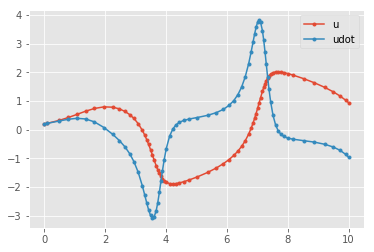

In [109]:
#Evaluate for k=2 (first test).  Things look OK.

u0 = numpy.array([.2, .2])
pyplot.figure()
hist, evals, errs = ode_rkexplicit(fhw(k=2).f, u0, rk_butcher_bs3(), tfinal=10, h0=.1,eps = 0.001)
times = [t for t,u in hist]
#pyplot.plot(times, [u for t,u in hist], '.',label='u')
pyplot.figure()
pyplot.plot(times, [u[0] for t,u in hist], '.-',label='u')
pyplot.plot(times, [u[1] for t,u in hist], '.-',label='udot')
pyplot.legend(loc='upper right');

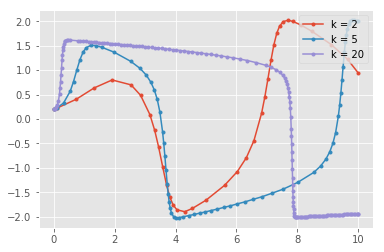

In [138]:
#Evaluate on k = 2,5 & 20.

tests = []
tests.append(fhw(k=2))
tests.append(fhw(k=5))
tests.append(fhw(k=20))

u0 = numpy.array([.2, .2])
pyplot.figure()
for test in tests:
    hist, evals, errs = ode_rkexplicit(test.f, u0, rk_butcher_bs3(), tfinal=10, h0=.1, eps = 0.01)
    times = [t for t,u in hist]
    pyplot.plot(times, [u[0] for t,u in hist], '.-',label = 'k = '+ str(test.k))
pyplot.legend(loc='upper right');

The graph above shows epsilon = 0.01.

I think this all checks out. For large values of k, very small time steps were required to get a well-behaved solution, so it makes sense that the k=20 case is using small steps.  The method is also clearly adapting, as seen in the big steps on the smooth parts of the k=2 curve, and small steps at the sharp corners.

#### Work Precision Diagram

Here I copied over the old Runge-Kutta explicit solver and updated it to use the BS3 butcher table, record the error at each time step, and count the number of function evaluations (like the one above). Now that I think of it I could have just added an adaptive=True input to the one above, but oh well..

In [111]:
## Constant Step Size Version 

def ode_rkexplicit_CSS(f, u0, butcher=None, tfinal=1, h=.1):
    if butcher is None:
        A, b3, b2 = rk_butcher_bs3()
    else:
        A, b3, b2 = butcher
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    errs = []
    hratio = 10
    evals = 0
    while t < tfinal:
        evals +=1
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        u += h * fY @ b3
        t = tnext
        eloc = numpy.linalg.norm(h*(b3-b2).reshape(1,4) @ fY.transpose()) 
        hist.append((t, u.copy()))
        errs.append(eloc)
    return hist, evals, errs

In [139]:
#New error functions, calculating infinity norm (max val) of local errors returned by new ode_rkexplicit functions

def error_CSS(h, rk_butcher,kin):
    hist, evals, errs  = ode_rkexplicit_CSS(fhw(k=kin).f, u0, rk_butcher_bs3(), tfinal=10, h=h)
    return numpy.linalg.norm(errs, numpy.inf), evals

def error_Adaptive(h, rk_butcher,kin,eps):
    hist, evals, errs  = ode_rkexplicit(fhw(k=kin).f, u0, rk_butcher_bs3(), tfinal=10, h0=h, eps=eps)
    return numpy.linalg.norm(errs, numpy.inf), evals

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in square


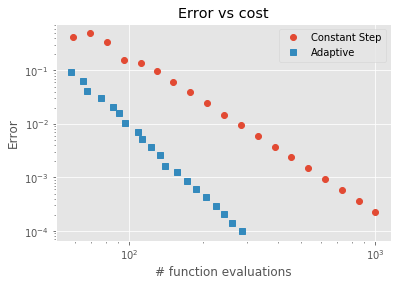

In [143]:
#Adaptive vs constant step work-precision comparison

k = 5

hs = numpy.logspace(-2, -.7, 20)
ep_vals = numpy.logspace(-1,-4, 20)
errsA = []
evalsA = []
errsC = []
evalsC = []
for h in hs:
    error_C, evals_C = error_CSS(h, rk_butcher_bs3,kin=k)
    errsC.append(error_C)
    evalsC.append(evals_C)
for ep in ep_vals: #Adaptive evaluated for a series of eps, since h changes.
    error_A, evals_A = error_Adaptive(0.1,rk_butcher_bs3,kin=k,eps = ep)
    errsA.append(error_A)
    evalsA.append(evals_A)
pyplot.loglog(evalsC, errsC, 'o', label='Constant Step')
pyplot.loglog(evalsA, errsA, 's', label='Adaptive')
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='upper right');

Seems to be working.  The adaptive method takes fewer evals for a given error, since it adjusts step size as necessary.

Below, this is evlauated at the 3 k-test values (2,5,20).  As expected, the difference between the adaptive and constant step methods increases at higher values of k, though it looks like after settling out it stays the same order.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in square


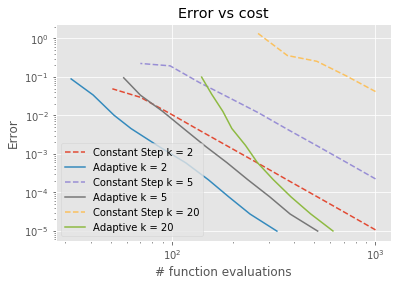

In [136]:
ks = [2,5,20]

hs = numpy.logspace(-2, -.7, 10)
ep_vals = numpy.logspace(-1,-5, 10)
for k in ks:
    errsA = []
    evalsA = []
    errsC = []
    evalsC = []
    for h in hs:
        error_C, evals_C = error_CSS(h, rk_butcher_bs3,kin=k)
        errsC.append(error_C)
        evalsC.append(evals_C)
    for ep in ep_vals:    
        error_A, evals_A = error_Adaptive(0.1,rk_butcher_bs3,kin=k,eps = ep)
        errsA.append(error_A)
        evalsA.append(evals_A)
    pyplot.loglog(evalsC, errsC, '--', label='Constant Step k = '+ str(k))
    pyplot.loglog(evalsA, errsA, '-', label='Adaptive k = '+ str(k))
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='lower left');